# Second step in pipeline

In [1]:
import os
import random
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

## Implement TopicTiling Algorithm (Riedl, Biemann, 2012)

In [33]:
# Functions for segmentation. Last function calls all of the above. 

def window_cosine_sim(dataframe, window_size=3):
    """
    Compute the cosine similarities between consecutive window blocks in a given dataframe.

    Args:
        dataframe (pandas.DataFrame): A dataframe containing topic probabilities.
        window_size (int, optional): The size of the window to use for cosine similarity computation. Defaults to 3.

    Returns:
        numpy.ndarray: An array of cosine similarities between consecutive window blocks.
    """
    transcript_cosine_similarities = [] 

    for p in range(window_size, len(dataframe)-window_size):
        w_l = dataframe.topic_probs[p-window_size:p]
        w_r = dataframe.topic_probs[p:p+window_size]

        # Add probability vectors in blocks
        w_l_added = np.add.reduce(w_l)
        w_r_added = np.add.reduce(w_r)

        # Compute cosine similarity between summed vecors of the windows
        transcript_cosine_similarities.append(np.dot(w_l_added, w_r_added)/(np.linalg.norm(w_l_added) * np.linalg.norm(w_r_added)))
        
    return np.array(transcript_cosine_similarities)


def find_minimas(window_cosines, window_size, print_state, height_param):
    """
    Find the minimas in the cosine similarity values.

    Args:
        window_cosines (numpy.ndarray): An array of cosine similarities between consecutive window blocks.
        window_size (int): The size of the window used for cosine similarity computation.
        print_state (bool): print information about candidate boundaries.
        height_param (float, optional): The minimum height for a peak to be considered a minima. Defaults to -0.995.

    Returns:
        numpy.ndarray: An array containing the indices of the identified minimas.
    """
    window_cosines_neg = window_cosines*-1
    # Find index of minimas
    minimas, _ = find_peaks(window_cosines_neg, height=height_param*-1)
    if print_state == 1:
        for position in minimas:
            print(f"Candidate boundary at sent. {position+window_size}, p:{position}, value (cos sim): {window_cosines[position]:.4f}")
    
    return minimas


def hl(p, cos_sims):
    """
    Compute the maximum value of the cosine similarities to the left of the given position.

    Args:
        p (int): The position in the cosine similarities array.
        cos_sims (numpy.ndarray): An array of cosine similarities.

    Returns:
        float: The maximum value of the cosine similarities to the left of the given position.
    """
    max_val = cos_sims[p]
    for i in range(p-1, 0, -1):
        if cos_sims[i] > max_val:
            max_val = cos_sims[i]
        else:
            break
    return max_val


def hr(p, cos_sims):
    """
    Compute the maximum value of the cosine similarities to the right of the given position.

    Args:
        p (int): The position in the cosine similarities array.
        cos_sims (numpy.ndarray): An array of cosine similarities.

    Returns:
        float: The maximum value of the cosine similarities to the right of the given position
    """
    max_val = cos_sims[p]
    for i in range(p+1, len(cos_sims)):
        if cos_sims[i] > max_val:
            max_val = cos_sims[i]
        else:
            break
    return max_val


def depth_scores(cos_sims, minimas):
    """
    Calculate the depth scores for each minima in the cosine similarities.
    Args:
    cos_sims (numpy.ndarray): An array of cosine similarities.
    minimas (numpy.ndarray): An array containing the indices of the identified minimas.

    Returns:
    list: A list of depth scores for each minima.
    """
    scores = []
    for p in minimas:
        dp = 0.5 * (hl(p, cos_sims) + hr(p, cos_sims) - cos_sims[p]*2)
        scores.append(dp)
    return scores


def segment_boundaries(depth_scores, minimas_list, window_size, print_state):
    """
    Determine the segment boundaries based on depth scores and a threshold value.
    Args:
    depth_scores (list): A list of depth scores for each minima.
    minimas_list (numpy.ndarray): An array containing the indices of the identified minimas.
    window_size (int): The size of the window used for cosine similarity computation.
    print_state (bool): print information about segment boundaries.


    Returns:
    list: A list of segment boundaries.
    """
    threshold = np.mean(depth_scores) - (np.std(depth_scores)/2)
    boundaries = []
    for index, score in enumerate(depth_scores):
        if score >= threshold:
            boundaries.append(minimas_list[index] + window_size)
            if print_state == 1:
                print(f"Boundary at sentence {minimas_list[index] + window_size}, p:{minimas_list[index]}, depth score: {score:.4f}")
    return boundaries


def plot_cosine_scores(cosine_similarities_for_windows, window_size, boundaries=None):
    """
    Plot the cosine similarities and negative cosine similarities over transcript windows.

    Args:
    cosine_similarities_for_windows (numpy.ndarray): An array of cosine similarities between consecutive window blocks.
    window_size (int): window sice of segmenter algorithm. Used in title.
    boundaries (list, optional): List of int:s containing placements of segment boundaries. 
    """
    plt.style.use(['science','no-latex'])
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    sns.lineplot(cosine_similarities_for_windows, ax=axs[0])
    axs[0].set_ylim(bottom=0, top=1)
    axs[0].set_xlabel("p")
    axs[0].set_ylabel("Cosine similarity")
    if boundaries != None:
        for seg_bound in boundaries:
            axs[0].axvline(seg_bound-window_size, color='r')

    neg_cosines_of_windows= cosine_similarities_for_windows*-1
    sns.lineplot(neg_cosines_of_windows, ax=axs[1])
    axs[1].set_ylim(bottom=-1, top=0)
    axs[1].set_xlabel("p")
    axs[1].set_ylabel("Negative cosine similarity")

    fig.suptitle(f"Cos. Sim. Over Transcript Windows with Segments Marked in Red [window size: {window_size}]")
    plt.show()


def segmentation_main_call(dataframe, print_state_min, print_state_depth, height=0.995, window=3):
    """
    Perform text segmentation by finding segment boundaries based on cosine similarity values.

    Args:
    dataframe (pandas.DataFrame): A dataframe containing topic probabilities.
    print_state_min (bool): print information about candidate boundaries.
    print_state_depth (bool): print information about segment boundaries.
    window_size (int, optional): The size of the window to use for cosine similarity computation. Defaults to 3.

    Returns:
    list: A list of segment boundaries.
    """
    window_cosines = window_cosine_sim(dataframe, window_size=window)
    min = find_minimas(window_cosines, print_state=print_state_min, window_size=window, height_param=height)
    ds = depth_scores(window_cosines, min)
    bounds = segment_boundaries(ds, min, window_size=window, print_state=print_state_depth)
    return bounds

## Pipeline step 2

In [3]:
# Load data
actual = pd.read_pickle('annotations.pkl')
annotated_probabilities = np.load('../Thesis/annotated_probabilities/topic_probability_density_vector_0bXWB28GwN8OiqC1ykRrRX.npy')

# make dataframe for processing
annotated_probabilities_df = pd.DataFrame({"sentence_no":[i for i in range(len(annotated_probabilities))], "topic_probs": list(annotated_probabilities)})
annotated_probabilities_df.head(5)

,sentence_no,topic_probs
0,0,"[2.7956062460606614e-11, 2.6173704813856194e-1..."
1,1,"[2.859866884990468e-07, 2.867863586454008e-07,..."
2,2,"[7.018507907263407e-66, 8.854125060834829e-66,..."
3,3,"[8.29493717915537e-154, 9.679648836114255e-154..."
4,4,"[4.168429810746567e-59, 4.07361789423125e-59, ..."


In [ ]:
def close_match(actual_breaks, predicted_breaks, close_definition=3): 
    """
    Find close matches between actual and predicted breaks. Returns accuracy, actual number of close matches and the positions of the close matches.
    """
    s = predicted_breaks
    new_set = set()
    for element in s:
        for i in range(1, close_definition+1): 
            new_set.add(element-i)
            new_set.add(element+i)
    s.update(new_set)

    intersection_actual_pred = actual_breaks.intersection(s)
    return (len(intersection_actual_pred)/len(actual_breaks)), len(intersection_actual_pred), intersection_actual_pred


actual = pd.read_pickle('annotations.pkl')


for dirpath, _, files in os.walk('../Thesis/annotated_probabilities'):
    
    episode = []; actual_breaks = []; predicted_breaks = []; exact_matches = []
    close_matches = []; accuracy = []; window_param = []; height_param = []

    for file in files:
        eps_id = file[:-4].split('_')[4]
        path = os.path.join(dirpath, file)
        with open(path, 'rb') as f: 
            topic_proba_dens_vector = np.load(f)
            annotated_probabilities_df = pd.DataFrame({"sentence_no":[i for i in range(len(topic_proba_dens_vector))], "topic_probs": topic_proba_dens_vector.tolist()})

            # get predicted bounds
            h = 0.75
            for win in range(10, 40, 2):
                predicted_bounds = segmentation_main_call(annotated_probabilities_df, print_state_min=False, print_state_depth=False, window=win, height=h)
                predicted_bounds_set = set(predicted_bounds)

                # get actual bounds
                actual_bounds = actual[actual.episode_id == eps_id].iloc[0,2]

                # get exact and close matches
                actual_bounds_set = set(actual_bounds)
                acc, num_matches, list = close_match(actual_bounds_set, predicted_bounds_set, close_definition=3)
                            
                # Append to build dataframe downstream
                episode.append(eps_id)
                actual_breaks.append(len(actual_bounds_set))
                predicted_breaks.append(len(predicted_bounds_set))
                exact_matches.append(len(predicted_bounds_set.intersection(actual_bounds_set)))
                close_matches.append(num_matches)
                accuracy.append(acc)
                window_param.append(win)
                height_param.append(h)
            
    
    evaluation_df = pd.DataFrame({'episode': episode,
                                  'actual_breaks': actual_breaks,
                                  'predicted_breaks': predicted_breaks,
                                  'exact_matches': exact_matches,
                                  'close_matches': close_matches,
                                  'accuracy_close_match': accuracy,
                                  'window_size': window_param,
                                  'height': height_param})

print(evaluation_df.shape)

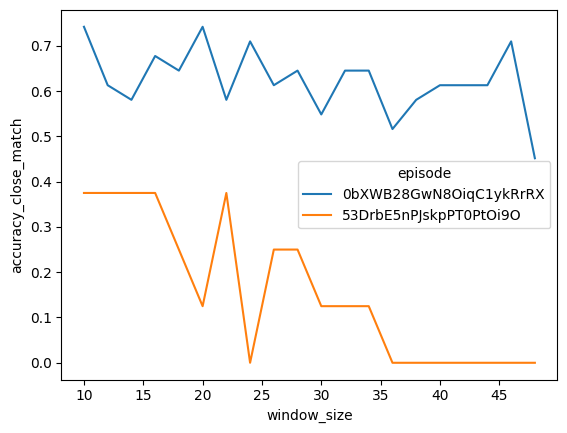

In [35]:
import seaborn as sns

sns.lineplot(data=evaluation_df, x='window_size', y = 'accuracy_close_match', hue='episode')
plt.show()

### Investigate individual transcripts

In [3]:
# load sentence probabilities from 1 step
sent_proba = np.load('probabilities.npy')
print(sent_proba.shape)

# make dataframe for processing
pipeline_df = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba))], "topic_probs": list(sent_proba)})
pipeline_df.head(5)

(599, 156)


,sentence_no,topic_probs
0,0,"[2.4833561188639078e-39, 2.5374959198157553e-3..."
1,1,"[9.579392743571795e-93, 9.994391142939728e-93,..."
2,2,"[1.1744153416560099e-56, 1.1848503397401329e-5..."
3,3,"[9.690914595314094e-93, 1.0109413697071008e-92..."
4,4,"[1.0595774955327207e-47, 1.0755329427821354e-4..."


1.0
1.3381358315896744e-68
0.16279383143526246


<Axes: >

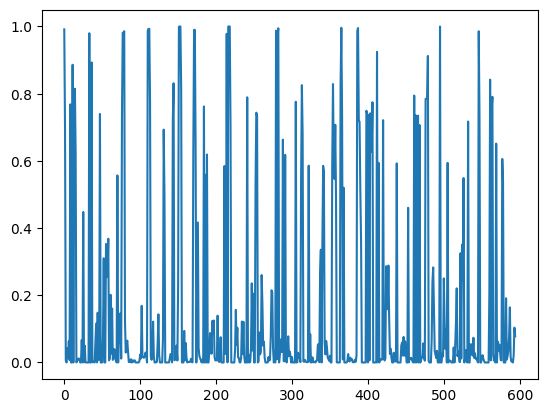

In [4]:
cos_sims = window_cosine_sim(pipeline_df, 2)
print(cos_sims.max())
print(cos_sims.min())
print(cos_sims.mean())
sns.lineplot(cos_sims)
plt.show()

Window size: 34, segments: 23


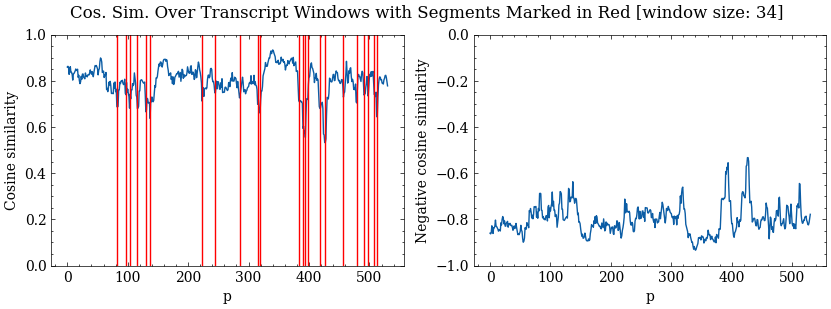

Window size: 35, segments: 18


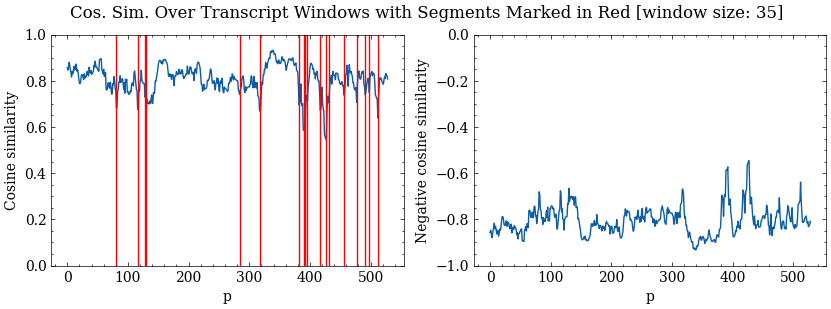

Window size: 36, segments: 19


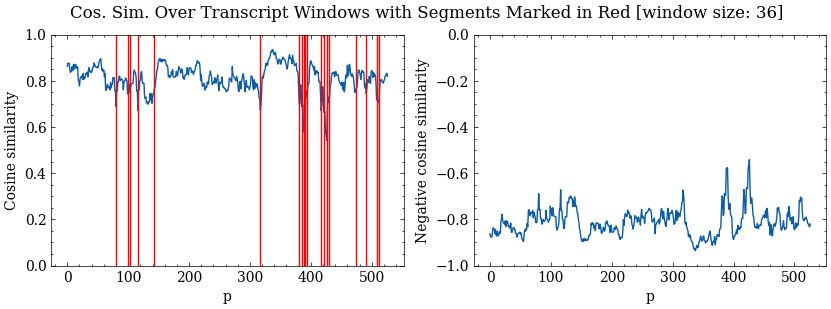

Window size: 37, segments: 9


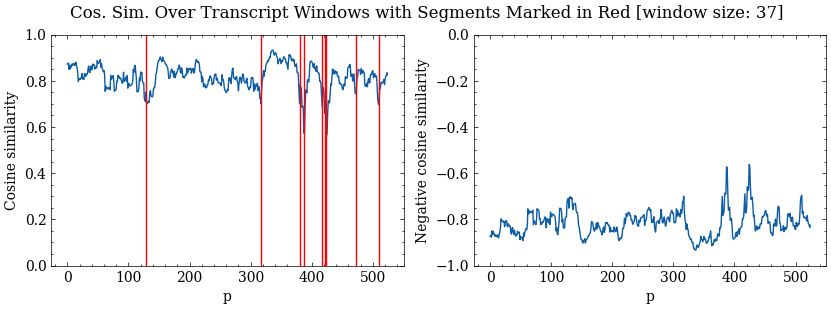

Window size: 38, segments: 8


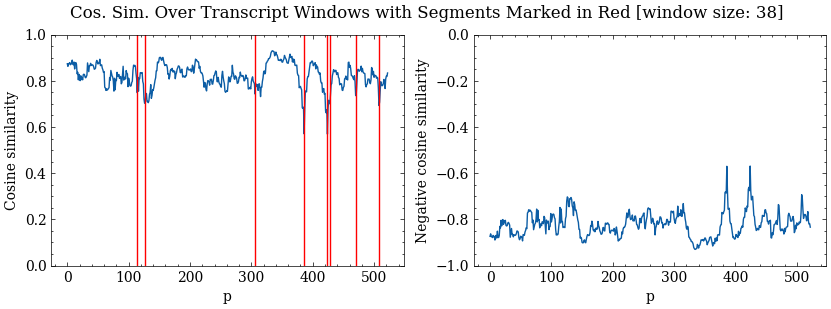

Window size: 39, segments: 6


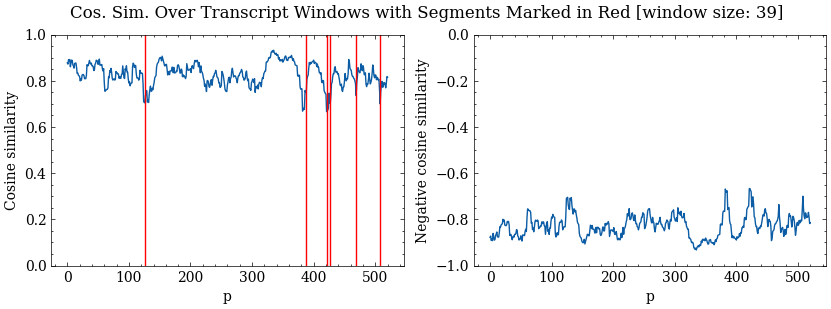

In [9]:
# Plot and analyse with different size windows
windows = [i for i in range(34, 40, 1)]

for win in windows:
    bounds = segmentation_main_call(pipeline_df, print_state_min=False, print_state_depth=False, window=win, height=0.75)
    cos_sims = window_cosine_sim(pipeline_df, window_size=win)
    print(f'Window size: {win}, segments: {len(bounds)}')
    plot_cosine_scores(cos_sims, window_size=win, boundaries=bounds)

## Testing with synthetic data

### Generate synthetic data

In [ ]:
# Generate synthetic topic probabilities
def generate_topic_probs(num_topics, num_sentences, topic_shift_interval):
    topic_probs = []

    np.random.seed(42)
    for i in range(num_sentences):
        if i % topic_shift_interval == 0:
            current_topic = np.random.dirichlet(np.ones(num_topics))
        
        noise = np.random.uniform(0.01, 0.05, num_topics)
        noisy_current_topic = current_topic + noise
        noisy_current_topic /= np.sum(noisy_current_topic)
        
        topic_probs.append(noisy_current_topic)

    return topic_probs

# Parameters for the synthetic dataset
num_topics = 5
num_sentences = 50
topic_shift_interval = 10

# Create the synthetic dataset
topic_probs = generate_topic_probs(num_topics, num_sentences, topic_shift_interval)

testing_df = pd.DataFrame({"sentence_no":[i for i in range(len(topic_probs))], "topic_probs": topic_probs})
testing_df.head()

### Testing

In [ ]:
# Evaluate differente window sizes on synthetic data

windows_ls = [i for i in range(1, 8, 1)]

for window in windows_ls:
    con_sim = window_cosine_sim(testing_df, window_size = window)
    plot_cosine_scores(con_sim, window_size=window)
    segmentation_main_call(testing_df, window=window, print_state_min=False, print_state_depth=True)
    print()
    print()